In [1]:
# TASKS
# TODO 1. Compare results for using early stopping and not using early stopping, maybe change the stopping criteria and the max patience
# TODO 2. Compare results for using 2 hidden layers as compared to only 1 (this will include a lot of coding changes, but sure helps in understanding the code better)
# TODO 3. Compare results for different hyperparameter values 
# TODO 4. Try to run a sweep locally on your machine using wandb, implementing grid search on chosen hyperparameters

In [2]:
import numpy as np 
import jax 
import jax.numpy as jnp
import time
from jax.example_libraries import optimizers
from sklearn.model_selection import train_test_split
from aux.ECG_utils import DummyArgs, ECGDataset, custom_collate_fn, init_weights_2layer
from aux.training_utils import run_epoch, j_v_prediction_per_sample
from torch.utils.data import DataLoader
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import resample
import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".70"

# parameters taken from the best-performing model after sweeping
args = DummyArgs()
print(args.__dict__)
args.batch_size = 256
args.lr = 0.002
args.tau_mem = 0.15
args.tau_mem_o = 0.01
args.num_hidden = 32
args.weight_gain = 0.4
args.seed = 0 
print(args.__dict__)

{'batch_size': 32, 'lr': 0.005, 'num_epochs': 1, 'tau_mem': 0.15, 'tau_mem_o': 0.1, 'Vth': 1, 'timestep': 0.002777777777777778, 'num_hidden': 64, 'weight_gain': 0.4, 'seed': 0}
{'batch_size': 256, 'lr': 0.002, 'num_epochs': 1, 'tau_mem': 0.15, 'tau_mem_o': 0.01, 'Vth': 1, 'timestep': 0.002777777777777778, 'num_hidden': 32, 'weight_gain': 0.4, 'seed': 0}


In [3]:
# Load delta modulated data
# multiclass classification
# # patient 208
X_train_dm, y_train = np.load('data/x_train_dm_208_multiclass.npy'), np.load('data/y_train_dm_208_multiclass.npy').astype(int) # patient 208
X_test_dm, y_test = np.load('data/x_test_dm_208_multiclass.npy'), np.load('data/y_test_dm_208_multiclass.npy').astype(int) # patient 208

# split the data into train, validation
X_train_dm, X_val_dm, y_train, y_val = train_test_split(X_train_dm, y_train, test_size=0.1, random_state=42)

# print shapes of X_train, X_val, X_test
print(f'\nX_train_dm shape: {X_train_dm.shape},\nX_val_dm shape: {X_val_dm.shape},\nX_test_dm shape: {X_test_dm.shape}')


X_train_dm shape: (2459, 250, 4),
X_val_dm shape: (274, 250, 4),
X_test_dm shape: (304, 250, 4)


In [4]:
# print class distribution
print(f'\nTrain class distribution: {np.unique(y_train, return_counts=True)}')
print(f'Val class distribution: {np.unique(y_val, return_counts=True)}')
print(f'Test class distribution: {np.unique(y_test, return_counts=True)}')


Train class distribution: (array([0, 1, 2, 3]), array([1371,    2,  770,  316]))
Val class distribution: (array([0, 2, 3]), array([139,  93,  42]))
Test class distribution: (array([0, 2, 3]), array([161, 129,  14]))


In [5]:
# remove class 1 from train data
X_train_dm, y_train = X_train_dm[y_train != 1], y_train[y_train != 1]

# print class distribution
print(f'\nTrain class distribution: {np.unique(y_train, return_counts=True)}')
print(f'Val class distribution: {np.unique(y_val, return_counts=True)}')
print(f'Test class distribution: {np.unique(y_test, return_counts=True)}')



Train class distribution: (array([0, 2, 3]), array([1371,  770,  316]))
Val class distribution: (array([0, 2, 3]), array([139,  93,  42]))
Test class distribution: (array([0, 2, 3]), array([161, 129,  14]))


In [6]:
# OPTIONAL  
# SMOTE the train dataset
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)

# randomly downsample class 0 (N) in X_train_dm to 50% of the original size, but keep other classes in dataset
# get indices of class 0 (N) and classes 1,2,3,4
idx_0 = np.where(y_train == 0)[0]
print(f'idx_0: {len(idx_0)}')
#idx_1 = np.where(y_train == 1)[0]
#print(f'idx_1: {len(idx_1)}')
idx_2 = np.where(y_train == 2)[0]
print(f'idx_2: {len(idx_2)}')
idx_3 = np.where(y_train == 3)[0]
print(f'idx_3: {len(idx_3)}')
#idx_4 = np.where(y_train == 4)[0]
#print(f'idx_4: {len(idx_4)}')
# downsample class 0 (N) to XX% of the original size
idx_0_downsampled = np.random.choice(idx_0, size=int(1*len(idx_0)), replace=False)
# concatenate indices of classes 0 downsampled and classes 1,2,3,4
idx_balanced = np.concatenate((idx_0_downsampled, idx_2, idx_3)) #idx_1, idx_4
# shuffle indices
np.random.shuffle(idx_balanced)
# get downsampled X_train_dm and y_train
X_train_dm = X_train_dm[idx_balanced]
y_train = y_train[idx_balanced]

idx_0: 1371
idx_2: 770
idx_3: 316


In [7]:
# print class distribution as percentage of X_train_dm
print(f'\nTrain class distribution: {np.unique(y_train, return_counts=True)[0]}: {np.unique(y_train, return_counts=True)}')


Train class distribution: [0 2 3]: (array([0, 2, 3]), array([1371,  770,  316]))


In [8]:
# concatenate all 4 delta modulated channels to one single channel in X_train_dm such that output shape is (n_samples, 4*250)
X_train_dm_smote = np.concatenate((X_train_dm[:,:,0], X_train_dm[:,:,1], X_train_dm[:,:,2], X_train_dm[:,:,3]), axis=1) # X_train_dm[:,:,1],
print(f'\nX_train_dm_smote shape: {X_train_dm_smote.shape}')

print(f'Shape X_train_dm before SMOTE: {X_train_dm_smote.shape}')
X_train_dm_smote, y_train_smote = smote.fit_resample(X_train_dm_smote, y_train)
print(f'Shape X_train_dm after SMOTE: {X_train_dm_smote.shape}')

print(f'\nTrain class distribution after SMOTE: {np.unique(y_train_smote, return_counts=True)}')
print(f'X_train_dm shape after SMOTE: {X_train_dm_smote.shape}')


X_train_dm_smote shape: (2457, 1000)
Shape X_train_dm before SMOTE: (2457, 1000)
Shape X_train_dm after SMOTE: (4113, 1000)

Train class distribution after SMOTE: (array([0, 2, 3]), array([1371, 1371, 1371]))
X_train_dm shape after SMOTE: (4113, 1000)


In [9]:
# print class distribution of smoted dataset
print(f'\nTrain class distribution after SMOTE: {np.unique(y_train_smote, return_counts=True)}')


Train class distribution after SMOTE: (array([0, 2, 3]), array([1371, 1371, 1371]))


In [10]:
# deconcatenate X_train_dm_smote to 4 channels again along axis 1 using np.split
print(f'\nX_train_dm_smote shape before deconcatenation: {X_train_dm_smote.shape}')


X_train_dm_smote shape before deconcatenation: (4113, 1000)


In [11]:
X_train_dm_final = np.moveaxis(np.stack(np.split(X_train_dm_smote, 4, axis=1), axis=0), 0, -1)
print(f'X_train_dm_final shape after deconcatenation: {X_train_dm_final.shape}')

X_train_dm_final shape after deconcatenation: (4113, 250, 4)


In [12]:
X_train_dm = X_train_dm_final
y_train = y_train_smote

In [13]:
train_loader = DataLoader(ECGDataset(X_train_dm, y_train),
                          batch_size=args.batch_size, shuffle=True, 
                          collate_fn=custom_collate_fn, drop_last=True)
val_loader = DataLoader(ECGDataset(X_val_dm, y_val), batch_size=args.batch_size, 
                        shuffle=True, collate_fn=custom_collate_fn, drop_last=True)
test_loader = DataLoader(ECGDataset(X_test_dm, y_test), batch_size=args.batch_size, 
                         shuffle=False, collate_fn=custom_collate_fn, drop_last=True)

In [14]:
# initialize the weights

out_multiclass_p208 = 3

key = jax.random.PRNGKey(0)
key, w_original = init_weights_2layer(key, 4, args.num_hidden, out_multiclass_p208, args.weight_gain)

# initialize the optimizer
opt_init, opt_update, get_params = optimizers.adam(step_size=args.lr)
opt_state = opt_init(w_original)

In [15]:
early_stopping = False

In [16]:
def train(hyperparams, n_epochs, opt_state, get_params, opt_update):

    print(f'batch_size = {args.batch_size}')
    key = jax.random.PRNGKey(0)
    best_train_acc = 0.000001
    best_train_f1 = 0.000001
    max_patience = 60
    patience = 0  # Early stopping
    print(f'{"Epoch": <6} | '
          f'{"Train loss": <15} | '
          f'{"Train acc": <15} | '
          f'{"Val acc": <15} | '
          f'{"Test acc": <15} | '
          f'{"Test Precision": <15} | '
          f'{"Test Recall": <15} | '
          f'{"Test F1": <15} | '
          f'{"Time": <15}')
    for e in range(n_epochs):
        epoch_start = time.time()
        key, opt_state, train_loss, train_acc, train_prec, train_rec, train_f1 = (
            run_epoch(key, train_loader, hyperparams, opt_state, get_params, 
                      e, opt_update)
        )
        key, _, val_loss, val_acc, val_prec, val_rec, val_f1 = (
            run_epoch(key, val_loader, hyperparams, opt_state, get_params)
        )
        time_epoch = time.time()
    
        key_test = jax.random.PRNGKey(0)
        _, _, test_loss, test_acc, test_prec, test_rec, test_f1 = (
            run_epoch(key_test, test_loader, hyperparams, opt_state, get_params)
        )
        if early_stopping and (train_acc > best_train_acc or train_f1 > best_train_f1):
            if ((train_acc - best_train_acc)/best_train_acc < 0.01 and train_acc > best_train_acc) or (train_f1 > best_train_f1 and (train_f1 - best_train_f1)/best_train_f1 < 0.01):
                patience += 1
                if patience == max_patience:
                    print(f'Early stopping at epoch {e}')
                    break
            else:
                best_train_acc = train_acc
                best_train_f1 = train_f1
                
                w_best = get_params(opt_state)
                opt_state_best = opt_state
                patience = 0
                #key_test 
                #jnp.save(f'weights/w_best.npy', w_best)    
            if e % 10 == 0:
                print(f'{e : <6} | '
                        f'{train_loss:.4f}{"":<9} | '
                        f'{train_acc:.4f}{"":<9} | '
                        f'{val_acc:.4f}{"":<9} | '
                        f'{test_acc:.4f}{"":<9} | '
                        f'{test_prec:.4f}{"":<9} | '
                        f'{test_rec:.4f}{"":<9} | '
                        f'{test_f1:.4f}{"":<9} | '
                        f'{time_epoch - epoch_start:.2f}{"":<9} | '
                        f'{patience:.2f}')
        else:
            if e % 10 == 0:
                print(f'{e : <6} | '
                        f'{train_loss:.4f}{"":<9} | '
                        f'{train_acc:.4f}{"":<9} | '
                        f'{val_acc:.4f}{"":<9} | '
                        f'{test_acc:.4f}{"":<9} | '
                        f'{test_prec:.4f}{"":<9} | '
                        f'{test_rec:.4f}{"":<9} | '
                        f'{test_f1:.4f}{"":<9} | '
                        f'{time_epoch - epoch_start:.2f}{"":<9} | '
                        f'{patience:.2f}')
            if early_stopping:
                    patience += 1
                    if patience == max_patience:
                        print(f'Early stopping at epoch {e}')
                        break
            
    return best_train_acc, opt_state, get_params, best_train_acc, train_loss, train_acc, val_acc, test_acc, test_prec, test_rec, test_f1, patience

In [17]:
hyperparams = (args.tau_mem, args.tau_mem_o, args.Vth, args.timestep)
_, opt_state, get_params, best_train_acc, train_loss, train_acc, val_acc, test_acc, test_prec, test_rec, test_f1, patience = train(hyperparams, 301, opt_state, get_params, opt_update)

batch_size = 256
Epoch  | Train loss      | Train acc       | Val acc         | Test acc        | Test Precision  | Test Recall     | Test F1         | Time           
0      | 1.8994          | 0.2729          | 0.3281          | 0.4375          | 0.4375          | 0.3333          | 0.2029          | 1.05          | 0.00
10     | 1.1754          | 0.6304          | 0.7969          | 0.9531          | 0.9528          | 0.6617          | 0.6482          | 0.27          | 0.00
20     | 1.1263          | 0.6492          | 0.8164          | 0.9492          | 0.9516          | 0.6587          | 0.6463          | 0.27          | 0.00
30     | 1.2745          | 0.6499          | 0.8398          | 0.9453          | 0.9472          | 0.6557          | 0.6433          | 0.27          | 0.00
40     | 1.4809          | 0.6467          | 0.8203          | 0.9492          | 0.9516          | 0.6587          | 0.6463          | 0.27          | 0.00
50     | 1.4462          | 0.6479          | 0.8125 

# Debug

In [18]:
from aux.debug import plot_net, out_debug, plot_Vh1
batch_spikes, batch_labels = next(iter(test_loader))

In [19]:
w = get_params(opt_state)
*state, out, loss, pred = (
    out_debug(batch_spikes, batch_labels, hyperparams, w)
)

(S_h1, I_h1, V_h1), (S_h2, I_h2, V_h2), (S_o, I_o, V_o) = state[0]

# print shapes
print(f'batch_spikes shape: {batch_spikes.shape}, batch_labels shape: {batch_labels.shape}')
print(f'S_h1 shape: {S_h1.shape}, I_h1 shape: {I_h1.shape}, V_h1 shape: {V_h1.shape}')
print(f'S_h2 shape: {S_h2.shape}, I_h2 shape: {I_h2.shape}, V_h2 shape: {V_h2.shape}')
print(f'S_o shape: {S_o.shape}, I_o shape: {I_o.shape}, V_o shape: {V_o.shape}')
print(f'out shape: {out.shape}, loss shape: {loss.shape}, pred shape: {pred.shape}')

# print pred
offset = 50
print(f'\npred: {pred[offset:(offset+25)]}')
print(f'lbls: {batch_labels[offset:(offset+25)]}')
print(f'same: {np.equal(pred, batch_labels)[offset:(offset+25)].astype(int)}')

# print manual accuracy
print(f'\nmanual accuracy: {np.mean(np.equal(pred, batch_labels))}')

loss: 0.19035038352012634, acc: 0.9375
batch_spikes shape: (256, 250, 4), batch_labels shape: (256,)
S_h1 shape: (256, 250, 32), I_h1 shape: (256, 250, 32), V_h1 shape: (256, 250, 32)
S_h2 shape: (256, 250, 16), I_h2 shape: (256, 250, 16), V_h2 shape: (256, 250, 16)
S_o shape: (256, 250, 3), I_o shape: (256, 250, 3), V_o shape: (256, 250, 3)
out shape: (256, 3), loss shape: (), pred shape: (256,)

pred: [0 2 0 0 0 2 0 0 2 0 0 0 2 0 2 2 0 0 2 0 0 2 0 0 2]
lbls: [0 2 2 0 0 2 0 0 2 2 0 0 2 0 3 2 0 0 2 0 0 2 0 0 2]
same: [1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1]

manual accuracy: 0.9375


w_original[0] == w[0]: False
loss: 1.1063454151153564, acc: 0.0
loss: 0.19035038352012634, acc: 0.9375


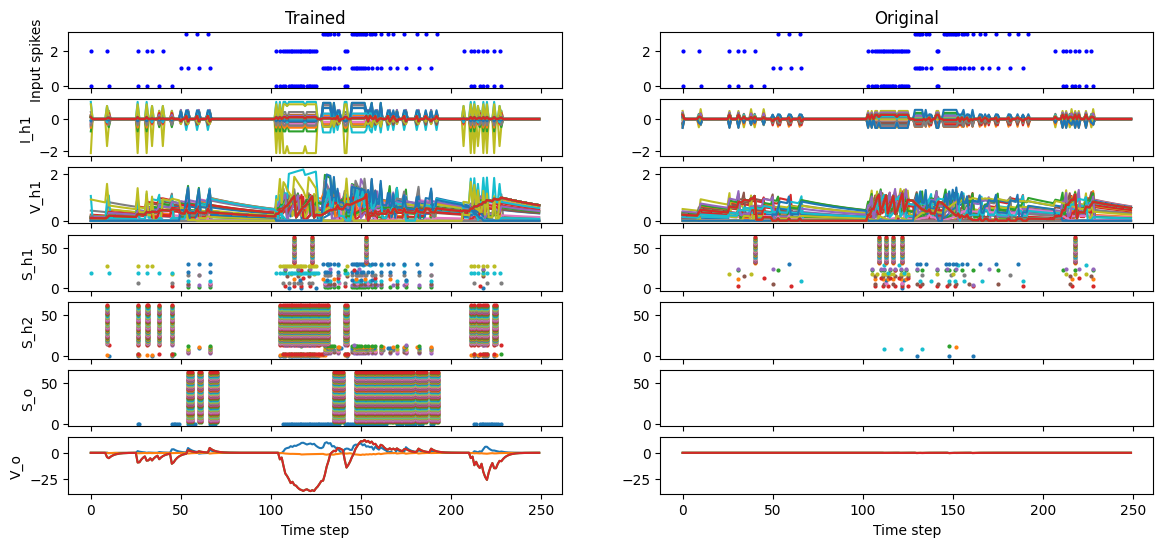

In [20]:
plot_net(get_params(opt_state), w_original, batch_spikes, batch_labels, hyperparams, 12)

loss: 0.19035038352012634, acc: 0.9375


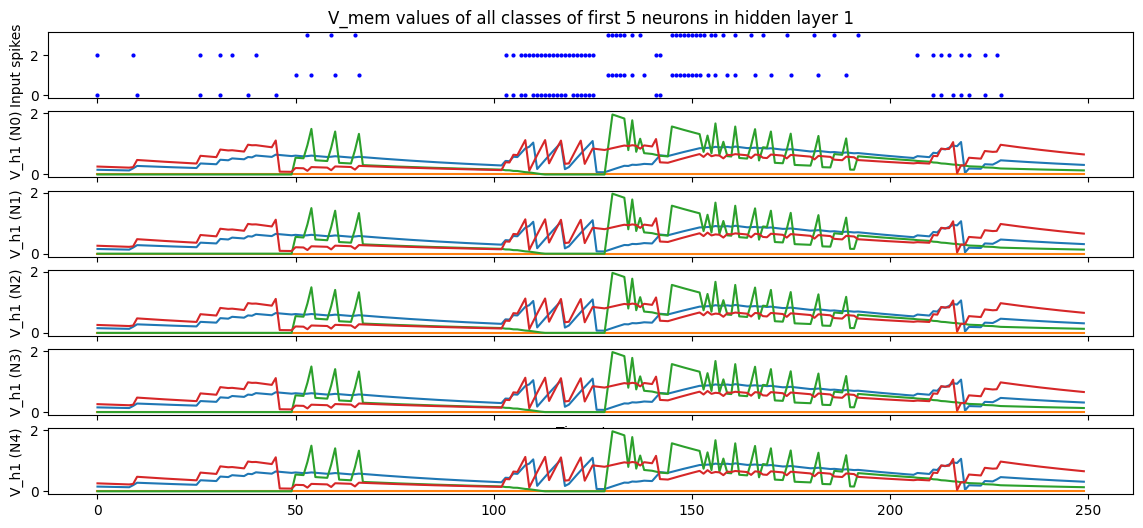

In [21]:
plot_Vh1(get_params(opt_state), batch_spikes, batch_labels, hyperparams, 12)

In [22]:
w = get_params(opt_state)
print(len(w))

print(w[0].shape)

print(w[0])

5
(32, 4)
[[ 0.08326914  0.02576728  0.07030209  0.01959629]
 [-0.28536585 -0.00702474 -0.08789822 -0.48076645]
 [-0.00961411  0.5494762  -0.00760895  0.4418921 ]
 [ 0.23862799  0.12518725  0.02100598 -0.0801539 ]
 [-0.04593244  0.56732863 -0.03629335  0.30400681]
 [-0.14329574  0.4852464  -0.17759994  0.19849434]
 [ 0.26549715  0.1358012  -0.14488639  0.07107783]
 [ 0.5155944   0.08237833 -0.08279326 -0.04667547]
 [-0.43421575  0.44155374 -1.6792893  -0.44481802]
 [-0.26703337  0.47933987 -0.19953112  0.20384589]
 [ 0.27369207  0.11731412 -0.19145861  0.10592052]
 [ 0.23296767  0.1069335  -0.12607525  0.10271243]
 [-0.5062552   0.1505502  -0.26076767 -0.15075491]
 [ 0.17578986 -0.28634852 -0.08696686  0.34425613]
 [-0.35273975 -0.05687125 -0.10697453 -0.26235393]
 [-0.04347897  0.09654204  0.2159499  -0.05746397]
 [ 0.23386529  0.29679775 -0.35101107  0.03279283]
 [-0.06352969  0.47421277 -0.1515286   0.3678892 ]
 [ 0.49211243 -0.01608619 -0.27842203  0.07834983]
 [ 0.25664473 -0.1521

loss: 1.1063454151153564, acc: 0.0


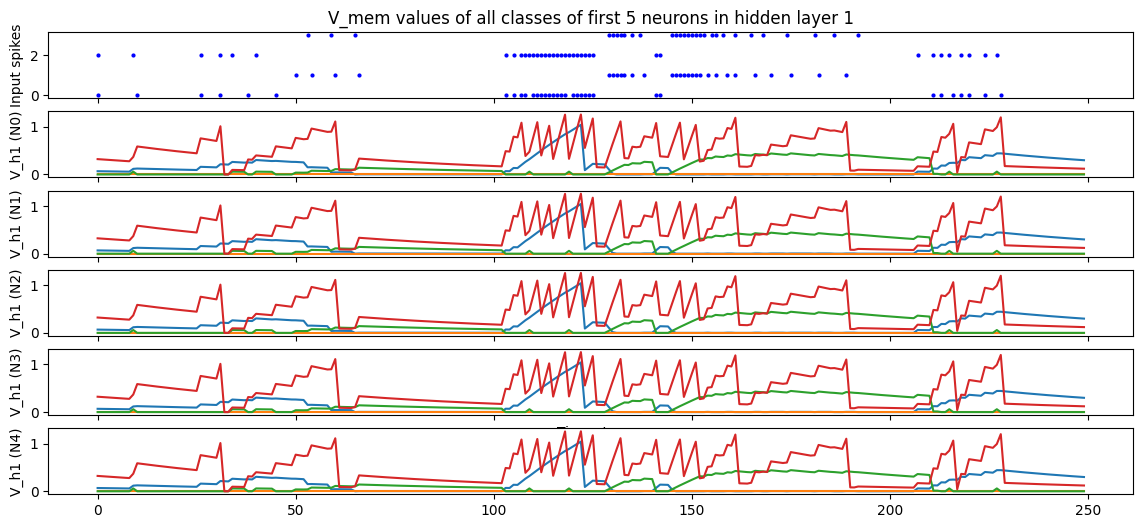

In [23]:
plot_Vh1(w_original, batch_spikes, batch_labels, hyperparams, 12)

(304, 250, 3)
(304, 3)
(304,)


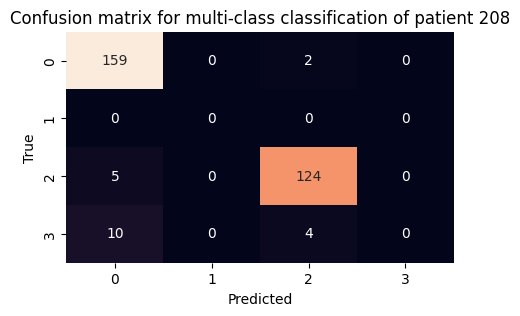


Class  | Recall   | Precision | Specificity | F1    
0      | 0.987578 | 0.9137931 | 0.895104895 | 0.949254
2      | 0.961240 | 0.9538462 | 0.963636364 | 0.957529
3      | 0.000000 | 0.0000000 | 0.000000000 | 0.000000

accuracy: 0.930921052631579


In [24]:
# plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

state = j_v_prediction_per_sample(get_params(opt_state), X_test_dm, hyperparams)
V_mem = state[2][2]
print(V_mem.shape) # (batch_size, sim_len ,out_dim)
max_per_class = jnp.max(V_mem, axis=1)
print(max_per_class.shape)
y_pred = jnp.argmax(max_per_class, axis=1)
print(y_pred.shape)

cm_dim = out_multiclass_p208+1 # class 1 is just left empty

# plot normalized confusion matrix manually without sklearn
cm = np.zeros((cm_dim, cm_dim))
for i in range(len(y_pred)):
    cm[y_test[i], y_pred[i]] += 1
#cm = cm / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm, index = [i for i in range(cm_dim)], columns = [i for i in range(cm_dim)])
plt.figure(figsize = (5,3))
sns.heatmap(df_cm, annot=True, fmt='g', cbar=False) # cmap='Blues'
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix for multi-class classification of patient 208')
plt.show()

# print f1, precision, recall without classification report
precision = np.zeros(cm_dim)
recall = np.zeros(cm_dim)
specificity = np.zeros(cm_dim)
f1 = np.zeros(cm_dim)

# formula for specificity 
# specificity = TN / (TN + FP) = TN / N = 1 - FPR

for i in range(out_multiclass_p208):
    precision[i] = cm[i,i] / cm[:,i].sum() if cm[:,i].sum() != 0 else np.nan
    recall[i] = cm[i,i] / cm[i,:].sum() if cm[i,:].sum() != 0 else np.nan
    # calculate specificity
    TN = cm[:i,:i].sum() + cm[i+1:,i+1:].sum()
    FP = cm[:i,i].sum() + cm[i+1:,i].sum()
    specificity[i] = TN / (TN + FP) if (TN + FP) != 0 else np.nan
    f1[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i]) if (precision[i] + recall[i]) != 0 else np.nan

# print recall, precision, specificity, f1 in a table for each class
print(f'\n{"Class": <6} | {"Recall": <8} | {"Precision": <9} | {"Specificity": <9} | {"F1": <6}')
for i in range(cm_dim):
    if i == 1:
        continue
    print(f'{i : <6} | {recall[i]:.6f} | {precision[i]:.7f} | {specificity[i]:.9f} | {f1[i]:.6f}')

# print ovreall accuracy
accuracy = np.mean(np.equal(y_pred, y_test))
print(f'\naccuracy: {accuracy}')

In [16]:
# # get weights
# w = get_params(opt_state)
# run_id = 'run0001'

# # save weights of current model in for loop
# for i in range(len(w)):
#     #if file does nor exist, create one
#     if not os.path.exists('weights'):
#         os.makedirs('weights')
#     jnp.save(f'weights/'+run_id+'_w_'+str(i)+'.npy', w[i])